In [1]:
%load_ext autotime

In [2]:
conda install -c conda-forge ipython-autotime

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
time: 11.6 s


In [3]:
import os
os.getcwd()

'/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/notebooks/census'

time: 15.4 ms


Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
time: 8.81 s


In [4]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from collections import Counter

from covid19_abm.dir_manager import get_data_dir

ModuleNotFoundError: No module named 'covid19_abm'

time: 2.12 s


In [7]:
age_map = {
    'less than 1 year': 0,
    'less than 1 year ': 0,
    '1 year': 1,
    '1 year ': 1,
    '2 years': 2,
    '2 years ': 2,
    '98': 98,
    '98 ': 98,
    'not reported/missing': None,
    'not reported/missing ': None,
}

econ_stat_map = {
    'Not working, inactive, not': 'Not working, inactive, not in universe',
}

time: 994 µs


In [8]:
os.listdir()

['Zimbabwe Raw Data Full Simulated School Mining Manufacturing.ipynb',
 'Zimbabwe Raw Data Full Simulated School Mining Manufacturing_sa.ipynb',
 '.ipynb_checkpoints']

time: 3.8 ms


In [9]:
full_individual_df = pd.read_stata( '../../data/raw/census_private/ABM_Simulated_Pop_WardDistributed_UpdatedMay30_school_complete_060520.dta')

time: 3min 32s


In [10]:
full_individual_df['age'] = full_individual_df['age'].map(lambda x: age_map.get(x, x))
full_individual_df['economic_status'] = full_individual_df['economic_status'].str.strip().map(lambda x: econ_stat_map.get(x, x))

time: 5.27 s


In [11]:
full_individual_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,new_dist_pop_share,geo1_zw,geo1_zw2012,geo1_string,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile
0,67786,4,21,1,19,female,0,2 families,"domestic and related helpers, cleaners and lau...",2,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
1,64925,3,21,1,49,male,0,2 families,travel attendants and related workers,1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
2,3648785,8,21,1,26,female,Secondary education teaching professionals,4 families,secondary education teaching professionals,2,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
3,127965,6,21,1,54,female,0,2 families,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
4,103824,5,21,1,65,female,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo


time: 313 ms


In [12]:
l = '''Not working, inactive, not in universe
In School
Homemakers/Housework
Office workers
Service Workers
Agriculture Workers
Indusrtry Workers
In the army
Disabled and not working'''
l = l.split('\n')
full_individual_df['economic_status'].value_counts()[l]

Not working, inactive, not in universe    5059625
In School                                 2828795
Homemakers/Housework                      1267806
Office workers                             465489
Service Workers                           2140208
Agriculture Workers                       2309064
Indusrtry Workers                          121116
In the army                                 41494
Disabled and not working                   169548
Name: economic_status, dtype: int64

time: 1.28 s


# Fill unknown age

In [13]:
individual_df = full_individual_df

time: 341 µs


In [14]:
# missing_val = 'not reported/missing'
age_cols = ['geo1_zw2012', 'urban', 'persons', 'sex', 'marst', 'citizen', 'race', 'disabled', 'economic_status']
X = pd.get_dummies(individual_df[age_cols], drop_first=True)

X_train = X[individual_df['age'].notnull()]

time: 18 s


In [15]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=1029)
# rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=1029, n_jobs=50)

frac = 0.05
X_tr = X_train.sample(frac=frac, random_state=1029)
gb.fit(X_tr, individual_df.loc[X_tr.index, 'age'])

missing_age = X[individual_df['age'].isnull()]

time: 1min 45s


<AxesSubplot:>

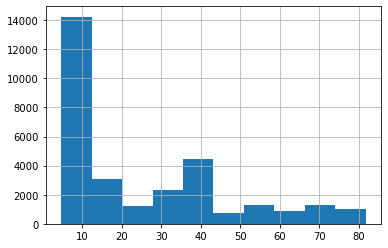

time: 1.15 s


In [16]:
pd.Series(gb.predict(missing_age)).hist()

In [17]:
X_tr.shape

(718623, 33)

time: 2.28 ms


In [18]:
individual_df.loc[missing_age.index, 'age'] = gb.predict(missing_age).astype(int)
individual_df.loc[missing_age.index].head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,new_dist_pop_share,geo1_zw,geo1_zw2012,geo1_string,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile
438,64898,3,21,1,37,male,0,1 family,motor-vehicle drivers,1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
3978,141744,8,21,1,9,male,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
6720,55301,3,21,1,19,male,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
7963,143945,8,21,1,7,male,0,8 families,niu (not in universe),8,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
9596,99018,5,21,1,20,female,0,2 families,"domestic and related helpers, cleaners and lau...",2,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo


time: 8.07 s


In [19]:
individual_df.economic_status.astype(str).value_counts()

Not working, inactive, not in universe    5059625
In School                                 2828795
Agriculture Workers                       2309064
Service Workers                           2140208
Homemakers/Housework                      1267806
Office workers                             465489
Disabled and not working                   169548
Indusrtry Workers                          121116
In the army                                 41494
Name: economic_status, dtype: int64

time: 3.69 s


## Create `ward_id`, `household_id` and `economic_activity_location_id`

In [20]:
pwd

'/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/notebooks/census'

time: 45.3 ms


In [21]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'ward_id',
    'economic_status', 'economic_activity_location_id',
    # 'household', 'ward'
]

time: 3.15 ms


In [22]:
old_new_districts = pd.read_csv('../../data/raw/district_relation.csv', index_col=0)
old_new_districts.index = old_new_districts['ADMIN_NAME'].str.lower()

time: 62.6 ms


In [23]:
individual_df['serial_expanded'] = individual_df['serial']

time: 110 ms


In [24]:
individual_df['household_id'] = individual_df['serial_expanded'].map(lambda x: f'h_{x}')
individual_df['old_ward_id'] = individual_df['geo2_zw2012'].map(lambda x: f'w_{old_new_districts["DIST2012"][x]}')                                          
individual_df['new_ward_id'] = individual_df['geo2_zw2012'].map(lambda x: f'w_{old_new_districts["NEW_DIST_ID_2"][x]}')

time: 9.38 s


In [25]:
expanded_individual_df = individual_df.copy()

time: 1min 29s


In [26]:
expanded_individual_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile,serial_expanded,household_id,old_ward_id,new_ward_id
0,67786,4,21,1,19,female,0,2 families,"domestic and related helpers, cleaners and lau...",2,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,67786,h_67786,w_21,w_1
1,64925,3,21,1,49,male,0,2 families,travel attendants and related workers,1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,64925,h_64925,w_21,w_1
2,3648785,8,21,1,26,female,Secondary education teaching professionals,4 families,secondary education teaching professionals,2,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,3648785,h_3648785,w_21,w_1
3,127965,6,21,1,54,female,0,2 families,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,127965,h_127965,w_21,w_1
4,103824,5,21,1,65,female,0,1 family,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,103824,h_103824,w_21,w_1


time: 146 ms


In [27]:
expanded_individual_df['school_goers'] = 1 * (expanded_individual_df['school_goers'] != 0)

time: 520 ms


In [28]:
expanded_individual_df.columns

Index(['serial', 'persons', 'district_id', 'new_district_id', 'age', 'sex',
       'teachers', 'nfams', 'isco88a', 'famunit', 'urban', 'economic_status',
       'gq', 'marst', 'citizen', 'race', 'disabled', 'disblnd', 'disdeaf',
       'dismntl', 'famsize', 'age2', 'edattain', 'edattaind', 'yrschool',
       'educzw', 'empstat', 'empstatd', 'labforce', 'occisco', 'occ',
       'manufacturing_workers', 'mining_workers', 'mining_districts', 'pid',
       'weight', 'ward', 'school_goers', 'school_goers_detailed', 'pernum',
       'geolev1', 'Province', 'Province_str', 'ProvincePop2012',
       'ProvincePop2019', 'geolev2', 'new_district_id_st', 'NewDistPop2012',
       'NewDistPop2019', 'new_dist_pop_share', 'geo1_zw', 'geo1_zw2012',
       'geo1_string', 'geo2_zw', 'geo2_zw2012', 'dhs_ipumsi_zw',
       'province_id_shpfile', 'province_name_shpfile', 'district_name_shpfile',
       'serial_expanded', 'household_id', 'old_ward_id', 'new_ward_id'],
      dtype='object')

time: 5.75 ms


In [29]:
expanded_individual_df.groupby('serial')['sex'].count().mean()

3.739394381540564

time: 5.15 s


In [30]:
expanded_individual_df.shape[0] / expanded_individual_df['serial'].nunique()

3.739394381540564

time: 1.28 s


In [31]:
(expanded_individual_df['school_goers'] == 1).sum()

2923907

time: 91.8 ms


In [32]:
(expanded_individual_df['school_goers'] == 1).sum()

2923907

time: 50.2 ms


# Mining

In [33]:
# relevant_cols = [
#     'person_id', 'age', 'sex',
#     'household_id', 'ward_id',
#     'economic_status', 'economic_activity_location_id',
#     'school_id_district', 
#     'manufacturing_workers',
#     'mining_district_id'
#     # 'household', 'ward'
# ]

relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'ward_id',
    'economic_status', 'economic_activity_location_id',
    # 'school_id_district', 
    'school_goers',
    'manufacturing_workers',
    # 'mining_district_id'
    # 'household', 'ward'
]

time: 537 µs


In [34]:
pwd

'/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/notebooks/census'

time: 5.12 ms


In [35]:
mining_df = expanded_individual_df.copy()

p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_ward_id']

try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'new_ward_id': 'ward_id'}, inplace=True)

mining_df[relevant_cols].to_pickle(
    ('../../data/preprocessed/census/zimbabwe_ipums_mining_manufacturing_school_new_dist_100pct.pickle'))

time: 3min 23s


In [36]:
mining_df[relevant_cols].head()

,person_id,age,sex,household_id,ward_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers
0,0,19,female,h_67786,w_1,Service Workers,w_1,0,0.0
1,1,49,male,h_64925,w_1,Service Workers,w_1,0,0.0
2,2,26,female,h_3648785,w_1,Office workers,w_1,1,0.0
3,3,54,female,h_127965,w_1,Homemakers/Housework,w_1,0,0.0
4,4,65,female,h_103824,w_1,"Not working, inactive, not in universe",w_1,0,0.0


time: 3.94 s


#### Contingent on available data

In [37]:
# mining_df['serial_expanded'] = mining_df['serial'].map(lambda x: f'{x}_01')
# mining_df['household_id'] = mining_df['serial_expanded'].map(lambda x: f'h_{x}')
mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'] = mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'].map(lambda x: f'mining_{x}')
mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'] = mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'].map(lambda x: f'school_{x}')

KeyError: 'mining_district_id'

time: 1.53 s


In [ ]:
mining_df.head()

In [ ]:
p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_ward_id']

In [ ]:
try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'new_ward_id': 'ward_id'}, inplace=True)

In [ ]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_5pct.pickle')

In [ ]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01') | mining_df.serial_expanded.str.endswith('_02')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
mining_df.shape

In [ ]:
import pandas as pd

In [ ]:
mining_df = pd.read_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
mining_df[mining_df['school_id_district'] != '']['person_id']

# Expand to 10%

In [ ]:
mining_df

# Scratch

In [ ]:
mining_df[~mining_df['household_id'].str.startswith('h_')]['person_id'].values

In [ ]:
mining_df[mining_df.manufacturing_workers.notnull()].person_id

In [ ]:
mining_df[mining_df['manufacturing_workers'].notnull()]['person_id'].values

In [ ]:
mining_df[mining_df['school_id_district'] != '']['person_id'].values

In [ ]:
mining_df['school_id_district'].shape